Abstractive Summarization: It chose words from data and there after rephrashing is done.

In [ ]:
!pip install transformers
!pip install datasets
!pip install py7zr

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail" , '3.0.0', split="train[:10]")

In [35]:
dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10
})

In [36]:
print(dataset[0]['article'])
print("\nSummary:\n")
print(dataset[0]['highlights'])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [37]:
from transformers import pipeline
summary = {}
pipe = pipeline('summarization', model = 'ubikpt/t5-small-finetuned-cnn')
output = pipe(dataset[0]['article'])
summary['t5-small'] = output[0]['summary_text']

pipe = pipeline('summarization', model='facebook/bart-large-cnn')
output = pipe(dataset[0]['article'])
summary['bart-large'] = output[0]['summary_text']

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [38]:
 for model in summary:
  print()
  print(model)
  print(summary[model])


t5-small
Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling

bart-large
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.


In [39]:
samsum = load_dataset('samsum', trust_remote_code=True)

In [40]:
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [41]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [42]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]


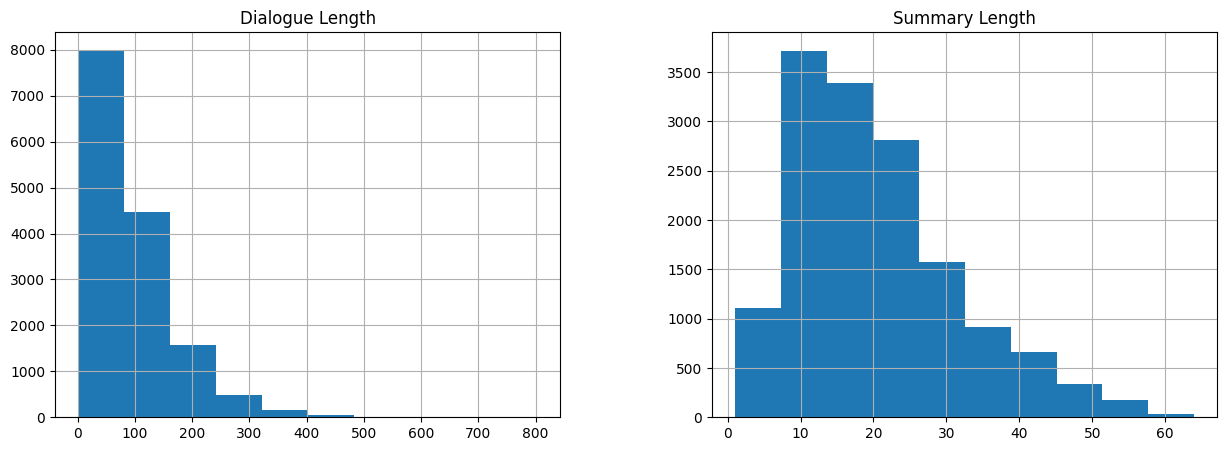

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.DataFrame([dialogue_len, summary_len]).T

data.columns = ["Dialogue Length","Summary Length"]
data.hist(figsize=(15,5))
plt.show()

##Model Loading and Tokenization

In [44]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model =  AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [45]:
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'])

{'input_ids': [21542, 10, 27, 13635, 5081, 5, 531, 25, 241, 128, 58, 16637, 10, 10625, 55, 21542, 10, 27, 31, 195, 830, 25, 5721, 3, 10, 18, 61, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [21542, 13635, 5081, 11, 56, 830, 16637, 128, 5721, 5, 1]}

In [46]:
def tokenize(batch):
  encoding = tokenizer(batch['dialogue'], text_target=batch['summary'], max_length=200, truncation=True, padding=True, return_tensors='tf')
  return encoding

In [47]:
samsum_tf = samsum.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [48]:
samsum_tf

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

##Model Training

In [53]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

data_collator =  DataCollatorForSeq2Seq(tokenizer, model=model)

args =  TrainingArguments(
    output_dir="train_dir",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay = 0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=500 # you can keep it low as 10 or 20
)

trainer =  Trainer(model=model,
                                args=args,
                                tokenizer=tokenizer,
                                data_collator=data_collator,
                                train_dataset=samsum_tf['train'],
                                eval_dataset=samsum_tf['validation']
                                )

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
0,No log,14.680170
1,No log,13.829660


TrainOutput(global_step=14, training_loss=14.086017063685826, metrics={'train_runtime': 837.6503, 'train_samples_per_second': 35.175, 'train_steps_per_second': 0.017, 'total_flos': 1480300953600000.0, 'train_loss': 14.086017063685826, 'epoch': 1.9006244909041543})

In [54]:
trainer.save_model("t5_samsum_summarization")

##Prediction

In [58]:
pipe = pipeline('summarization', model='t5_samsum_summarization', device=0)
custom_dialogue="""
Ranjeet: what work you planning to give pankaj?
Sangram: I was hoping to send him on a bussiness trip first.
Ranjeet: cool. is there any suitable work for him?
Sangram: he did excellent in last quarter. I will assign new project, once he is back.
"""
output = pipe(custom_dialogue)
output

Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


[{'summary_text': "he did excellent in last quarter . he will assign new project once he is back . Sangram: i'm going to send him on a bussiness trip first ."}]